In [1]:
# Master File for Offline Studies on Muon System LLP Decays (sans clustering)

# Coders: Nathan Suri, Caltech; Cristian Pena, Caltech/Fermilab
# Date: July 2019
# LPC LLP Group

# Description
# Meant for initially dealing with large data files

# Action Plan
#

# Notes/Conclusions
# @nasurijr: Barrel acceptance (theoretical rationale, data supports acceptance trend)

In [2]:
# Setups pwd location for data files and imports of special ROOT utilities

work_location = input("Username: ")
if work_location == 'nasurijr':
    pwd = '/nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/'
# elif work_location == '<Insert Tier2 username here>':
#     pwd = '/home/cms/delayed_jet_analyzer/'

Username: nasurijr


# Imports

In [3]:
# Imports necessary utilities and modules

import ROOT as rt
import root_numpy as rtnp
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

# Graph/histo utilities from ROOT
# Contained within the delayed_jet_analyzer repository
import sys
sys.path.append(pwd+'lib')
from histo_utilities import create_TH1D, create_TH2D, create_TGraph, std_color_list

# Used for extracting the TTree structure from each datafile
import os
import uproot

donotdelete = []

Welcome to JupyROOT 6.18/00


# Read in and Extract TTrees from Datafiles

In [4]:
# Setups dictionaries for storing data from MC/data ntuples
fpath = {}
tree = {}

data_path = pwd+'data/'

# Background Samples
fpath['qcd'] = data_path +'jet_timing_studies_ntuple_RunIIFall17DRPremix_QCD_Pt_170to300_TuneCP5_13TeV_pythia8_1.root'

# Small subset of B samples for quick runs/tests
fpath['zeroBias'] = data_path + 'jet_timing_studies_ZeroBias_Run2018B_112_dec.root'
# # Complete set of A and B ZeroBias samples (time-intensive to run)
# fpath['zeroBias'] = data_path + 'jet_timing_studies_ZeroBias_Run2018AB_complete.root'

################################################################

# Signal Samples
# mH = 125 GeV, mX = 50 GeV, ctau = 1 m
fpath['m50ct1000mm'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl1000_ev100000.root'

# mH = 125 GeV, mX = 50 GeV, ctau = 10 m
fpath['m50ct10000mm'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl10000_ev100000.root'

# mH = 2000 GeV, mX = 975 GeV, ctau = 1 m
fpath['m975ct1000mm'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh2000_mx975_pl1000_ev100000.root'

# mH = 2000 GeV, mX = 975 GeV, ctau = 10 m
fpath['m975ct10000mm'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh2000_mx975_pl10000_ev100000.root'

# Iterates through each file and extracts the ROOT TTree structure from each
for k,v in fpath.items():
    print(str(datetime.datetime.now(pytz.timezone('US/Pacific'))))
    print(k, v)
    root_dir = uproot.open(v) 
    tree[k] = root_dir['ntuples']['llp']
    # Accesses the array form of the jetPt branch
#     a = tree[k]["jetPt"].array()
#     print(a[:-1][0])

2019-07-25 14:44:01.241657-07:00
qcd /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/jet_timing_studies_ntuple_RunIIFall17DRPremix_QCD_Pt_170to300_TuneCP5_13TeV_pythia8_1.root
2019-07-25 14:44:01.389844-07:00
zeroBias /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/jet_timing_studies_ZeroBias_Run2018B_112_dec.root
2019-07-25 14:44:01.639767-07:00
m50ct1000mm /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl1000_ev100000.root
2019-07-25 14:44:01.794124-07:00
m50ct10000mm /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl10000_ev100000.root
2019-07-25 14:44:01.945408-07:00
m975ct1000mm /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/jet_timing_studies_ntuple_metbb_ggh_ISR_mh2000_mx975_pl1000_ev100000.root
2019-07-25 14:44:02.112136-07:00
m975ct10000mm /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/jet_timing_studies_ntuple_metbb_ggh

## Name TTree Objects

In [5]:
# Bookkeeping: Defines the TTrees from the read datafiles
# Names displayed in README.md table

T = tree['m50ct1000mm']
T_bkg = tree['qcd']
T_minBias = tree['zeroBias']
T_low_ctau10 = tree['m50ct10000mm']
T_high_ctau1 = tree['m975ct1000mm']
T_high_ctau10 = tree['m975ct10000mm']

## Jet Pt Calculations

In [6]:
#get first jet pt per event
first_jet_pt = [x[0] if len(x) else -1 for x in T['jetPt'].array()]

#get max jet pt per event
max_jet_pt = [np.max(np.abs(x)) if len(x) else -1 for x in T['gLLP_decay_vertex_z'].array()]

#store jet-pt array per event in a list
first_jet_pt_arr = []
for x in T['jetPt'].array():
    if len(x) == 0:
        break
    first_jet_pt_arr.append(x[0])

# Define Variables and Name Datafiles 

In [7]:
# Variable Definitions
# Creates dictionaries for variables to be analyzed
# The dictionaries will contain the variable arrays for each datafile with a relevant key

# CSC
nCsc = {}
csc_z = {}
csc_x = {}
csc_y = {}
csc_eta = {}
csc_phi = {}
# Gen Level
gLLP_eta = {}
gLLP_r = {}
gLLP_decay = {}
eventNum = {}
lumiNum = {}
# Drift Tube (DT)
nDt = {}
dt_phi = {}
dt_eta = {}
dt_z = {}
dt_x = {}
dt_y = {}
# RPC
nRpc = {}
rpc_phi = {}
rpc_eta = {}
rpc_z = {}
rpc_x = {}
rpc_y = {}

In [8]:
# Bookkeeping: Creates a dictionary for iterating over all of the datafiles and 
#              converting the relevant branches to numpy arrays
# Names displayed in README.md table

data_trees = {'m50ct1m': T, 'qcd': T_bkg, 'zeroBias':T_minBias, 'm50ct10m': T_low_ctau10, 'm975ct1m': T_high_ctau1, 'm975ct10m': T_high_ctau10}

## Event Selection and TBranch -> np.array() Conversion

In [9]:
# Event Selection

print('Start: ' + str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

# MET+bb Final State
if 'metbb' in fpath['m50ct1000mm']:
    for species, arbor in data_trees.items():
        
        gLLP_r[species] = np.sqrt((arbor['gLLP_decay_vertex_x'].array()[:,0])**2+(arbor['gLLP_decay_vertex_y'].array()[:,0])**2)
        gLLP_decay[species] = np.sqrt((arbor['gLLP_decay_vertex_x'].array()[:,0])**2+(arbor['gLLP_decay_vertex_y'].array()[:,0])**2 + (arbor['gLLP_decay_vertex_z'].array()[:,0])**2)
        
        # Endcap Signal Event Selection: Requires that the bb-decaying LLP decays within the endcap of the muon system        
        sel_csc = np.logical_and(np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) > 568 , np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) < 1100)
        sel_csc = np.logical_and(sel_csc, np.absolute(arbor['gLLP_eta'].array()[:,0])<2.4)
        sel_csc = np.logical_and(sel_csc, np.absolute(arbor['gLLP_eta'].array()[:,0])>0.9)
        sel_csc = np.logical_and(sel_csc, np.absolute(gLLP_r[species])<695.5)

        # Barrel Signal Event Selection: Requires that the bb-decaying LLP decays within the barrel of the muon system        
        sel_barrel = np.logical_and(np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) > -661 , np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) < 661)
        sel_barrel = np.logical_and(sel_barrel, np.absolute(gLLP_r[species])<738)
        sel_barrel = np.logical_and(sel_barrel, np.absolute(gLLP_r[species])>380)

        # Overlap Signal Event Selection: Requires that the bb-decaying LLP decays within the overlap of the barrel
        #                                 and endcap of the muon system
        sel_rpc = np.logical_and(np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) > 0 , np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) < 1100)
        sel_rpc = np.logical_and(sel_rpc, np.absolute(arbor['gLLP_eta'].array()[:,0])<1.6)
        sel_rpc = np.logical_and(sel_rpc, np.absolute(gLLP_r[species])<738)
        sel_rpc = np.logical_and(sel_rpc, np.absolute(gLLP_r[species])>275)

        # Total Muon System Signal Event Selection: Logical or of barrel and endcap gen-level restrictions
        sel_dis_signal = np.logical_or(sel_csc, sel_barrel)

        # Converts variable branches to numpy arrays with event selection
        # Signal conversions
        if species in ('m50ct1m', 'm50ct10m', 'm975ct1m', 'm975ct10m'):
            # Endcap: CSCs
            nCsc[species] = arbor['nCsc'].array()[sel_csc]
            csc_z[species] = arbor['cscZ'].array()[sel_csc]
            csc_x[species] = arbor['cscX'].array()[sel_csc]
            csc_y[species] = arbor['cscY'].array()[sel_csc]
            csc_eta[species] = arbor['cscEta'].array()[sel_csc]
            csc_phi[species] = arbor['cscPhi'].array()[sel_csc]
            
            # Gen-level
            gLLP_eta[species] = arbor['gLLP_eta'].array()[:,0][sel_csc]
            eventNum[species] = arbor['eventNum'].array()[sel_csc]
            lumiNum[species] = arbor['lumiNum'].array()[sel_csc]
            
            # Barrel: DTs
            nDt[species] = arbor['nDt'].array()[sel_barrel]
            dt_z[species] = arbor['dtZ'].array()[sel_barrel]
            dt_x[species] = arbor['dtX'].array()[sel_barrel]
            dt_y[species] = arbor['dtY'].array()[sel_barrel]
            dt_eta[species] = arbor['dtEta'].array()[sel_barrel]
            dt_phi[species] = arbor['dtPhi'].array()[sel_barrel]
            
            # Overlap: RPCs
            nRpc[species] = arbor['nRpc'].array()[sel_rpc]
            rpc_z[species] = arbor['rpcZ'].array()[sel_rpc]
            rpc_x[species] = arbor['rpcX'].array()[sel_rpc]
            rpc_y[species] = arbor['rpcY'].array()[sel_rpc]
            rpc_eta[species] = arbor['rpcEta'].array()[sel_rpc]
            rpc_phi[species] = arbor['rpcPhi'].array()[sel_rpc]
        
        # Background conversions
        if species in ('qcd', 'zeroBias'):
            # Background event selection: Requires at least one jet per event to have pT > 50 GeV
            sel_bkg = [True if np.any(x > 50) else False for x in arbor['jetPt'].array()]
            
            # Endcap: CSCs
            nCsc[species] = arbor['nCsc'].array()[sel_bkg]
            csc_z[species] = arbor['cscZ'].array()[sel_bkg]
            csc_x[species] = arbor['cscX'].array()[sel_bkg]
            csc_y[species] = arbor['cscY'].array()[sel_bkg]
            csc_eta[species] = arbor['cscEta'].array()[sel_bkg]
            csc_phi[species] = arbor['cscPhi'].array()[sel_bkg]
            gLLP_eta[species] = arbor['gLLP_eta'].array()[:,0][sel_bkg]
            
            # Gen-level
            eventNum[species] = arbor['eventNum'].array()[sel_bkg]
            lumiNum[species] = arbor['lumiNum'].array()[sel_bkg]
            
            # Barrel: DTs
            nDt[species] = arbor['nDt'].array()[sel_bkg]
            dt_z[species] = arbor['dtZ'].array()[sel_bkg]
            dt_x[species] = arbor['dtX'].array()[sel_bkg]
            dt_y[species] = arbor['dtY'].array()[sel_bkg]
            dt_eta[species] = arbor['dtEta'].array()[sel_bkg]
            dt_phi[species] = arbor['dtPhi'].array()[sel_bkg]
            
            # Overlap: RPCs
            nRpc[species] = arbor['nRpc'].array()[sel_bkg]
            rpc_z[species] = arbor['rpcZ'].array()[sel_bkg]
            rpc_x[species] = arbor['rpcX'].array()[sel_bkg]
            rpc_y[species] = arbor['rpcY'].array()[sel_bkg]
            rpc_eta[species] = arbor['rpcEta'].array()[sel_bkg]
            rpc_phi[species] = arbor['rpcPhi'].array()[sel_bkg]
        
        print(species + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

Start: 2019-07-25 14:44:03.424209-07:00
m50ct1m: 2019-07-25 14:44:03.810117-07:00
qcd: 2019-07-25 14:44:04.894697-07:00
zeroBias: 2019-07-25 14:45:00.571330-07:00
m50ct10m: 2019-07-25 14:45:00.982046-07:00
m975ct1m: 2019-07-25 14:45:01.168733-07:00
m975ct10m: 2019-07-25 14:45:01.497062-07:00


## Endcap Hit Removal

# Endcap Offline Study

In [10]:
# Hit Removal
# For both the endcap and barrel regions (overlap to be determined), the closest stations to the beamspot are the noisiest.
# Thus, we remove the hits that land in these stations for each event in each datafile.

# Endcap
nCsc_station = {}
nCsc_removal = {}

# Loops over every datafile
for files in data_trees.keys():
    # Endcap
    nCsc_station[files] = {}
    nCsc_station[files]['ME_11'] = []
    nCsc_station[files]['ME_12'] = []
    nCsc_station[files]['ME_13'] = []
    
    # Loops over every event in each datafile
    for pos_bool in range(len(csc_z[files])):
        csc_r = np.sqrt(csc_x[files][pos_bool]**2+csc_y[files][pos_bool]**2)
        z_pos_bool = csc_z[files][pos_bool]
        
        counter_me11 = 0
        counter_me12 = 0
        counter_me13 = 0
        
        # Loops over every hit in each event
        for z_ind in range(len(z_pos_bool)):
            z_bool = np.absolute(z_pos_bool[z_ind])
            # ME 1/1 Constraints
            if z_bool > 568 and z_bool < 632:
                counter_me11 += 1
                
            if z_bool > 663 and z_bool < 724:
                # ME 1/2 Constraints
                if csc_r[z_ind] < 465 and csc_r[z_ind] > 275:
                    counter_me12 += 1
                # ME 1/3 Constraints
                if csc_r[z_ind] < 695.5 and csc_r[z_ind] > 505.5:
                    counter_me13 += 1
                    
        nCsc_station[files]['ME_11'].append(counter_me11)
        nCsc_station[files]['ME_12'].append(counter_me12)
        nCsc_station[files]['ME_13'].append(counter_me13)
    
    # nCsc dictionaries containing hits removed labelled by removed stations
    nCsc_removal[files] = {}
    nCsc_removal[files]['ME_11'] = np.array(nCsc[files]) - np.array(nCsc_station[files]['ME_11'])
    nCsc_removal[files]['ME_112'] = np.array(nCsc[files]) - (np.array(nCsc_station[files]['ME_11']) + np.array(nCsc_station[files]['ME_12']))
    nCsc_removal[files]['ME_1123'] = np.array(nCsc[files]) - (np.array(nCsc_station[files]['ME_11']) + np.array(nCsc_station[files]['ME_12']) + np.array(nCsc_station[files]['ME_13']))
    
    print(files + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

m50ct1m: 2019-07-25 14:45:02.490861-07:00
qcd: 2019-07-25 14:45:10.434304-07:00
zeroBias: 2019-07-25 14:45:13.026982-07:00
m50ct10m: 2019-07-25 14:45:15.488311-07:00
m975ct1m: 2019-07-25 14:45:15.507043-07:00
m975ct10m: 2019-07-25 14:45:20.518856-07:00


## *Endcap Inclusive N<sub>CSC</sub> Histogram*

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: nCsc_m50ct1m (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nCsc_qcd (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nCsc_zeroBias (Potential memory leak).
Info in <TCanvas::Print>: pdf file ncsc_inclusive_mc_zeroBias.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: ncsc_inclusive_mc_zeroBias.C has been generated


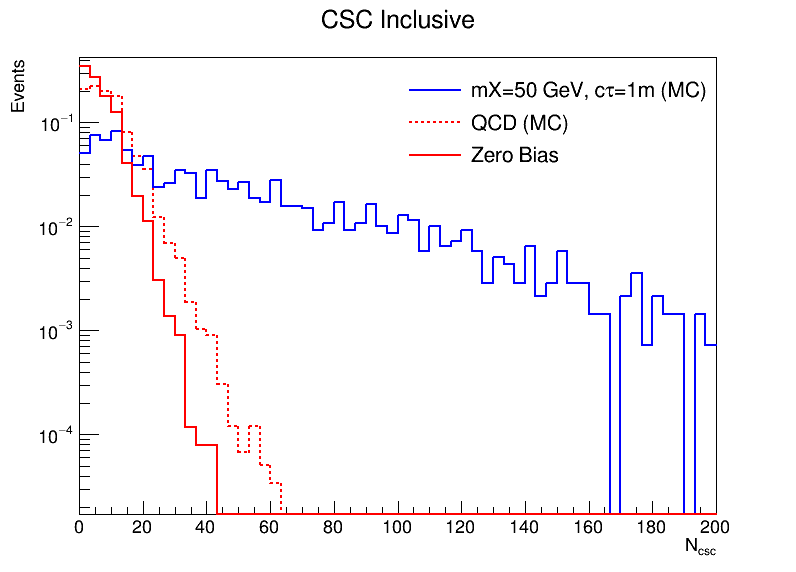

In [25]:
# Creates a 1D histogram of the number of CSC hits for the m50ct1m signal MC, QCD MC, and ZeroBias data 
# with no hit removal

c = rt.TCanvas('c','c', 800, 600)
h = {}
h['nCsc_m50ct1m'] = create_TH1D(nCsc['m50ct1m'], axis_title=['nCsc_m50ct1m', 'Events'], name='nCsc_m50ct1m', binning=[150,0,500])
h['nCsc_m50ct1m'].SetLineColor(4)

h['nCsc_qcd'] = create_TH1D(nCsc['qcd'], axis_title=['nCsc_qcd', 'Events'], name='nCsc_qcd', binning=[150,0,500])
h['nCsc_qcd'].SetLineColor(2)
h['nCsc_qcd'].SetLineStyle(2)


h['nCsc_zeroBias'] = create_TH1D(nCsc['zeroBias'], axis_title=['nCsc_zeroBias', 'Events'], name='nCsc_zeroBias', binning=[150,0,500])
h['nCsc_zeroBias'].SetLineColor(2)
h['nCsc_zeroBias'].SetLineStyle(1)

c.SetLogy()

h['nCsc_m50ct1m'].Scale(1.0/h['nCsc_m50ct1m'].Integral())
h['nCsc_qcd'].Scale(1.0/h['nCsc_qcd'].Integral())
h['nCsc_zeroBias'].Scale(1.0/h['nCsc_zeroBias'].Integral())


h['nCsc_m50ct1m'].SetLineWidth(2)
h['nCsc_qcd'].SetLineWidth(2)
h['nCsc_zeroBias'].SetLineWidth(2)

h['nCsc_m50ct1m'].GetXaxis().SetRangeUser(0,200)
h['nCsc_qcd'].GetXaxis().SetRangeUser(0,200)
h['nCsc_zeroBias'].GetXaxis().SetRangeUser(0,200)


h['nCsc_qcd'].SetStats(0)
h['nCsc_qcd'].SetTitle("CSC Inclusive")
h['nCsc_qcd'].SetXTitle("N_{csc}")


h['nCsc_qcd'].Draw('histo')
h['nCsc_m50ct1m'].Draw('histo+same')
h['nCsc_zeroBias'].Draw('histo+same')

legend = rt.TLegend(0.50,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
#legend-.SetFillStyle(0);
legend.AddEntry( h['nCsc_m50ct1m'], "mX=50 GeV, c#tau=1m (MC)" , "L");
legend.AddEntry( h['nCsc_qcd'], "QCD (MC)" , "L");
legend.AddEntry( h['nCsc_zeroBias'], "Zero Bias" , "L");

legend.Draw();

c.Draw()

c.SaveAs("ncsc_inclusive_mc_zeroBias.pdf")
c.SaveAs("ncsc_inclusive_mc_zeroBias.C")

## *N<sub>CSC</sub> Histogram with ME 1/1 Hits Removed*

Info in <TCanvas::Print>: pdf file ncsc_noME11_mc_zeroBias.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: ncsc_noME11_mc_zeroBias.C has been generated


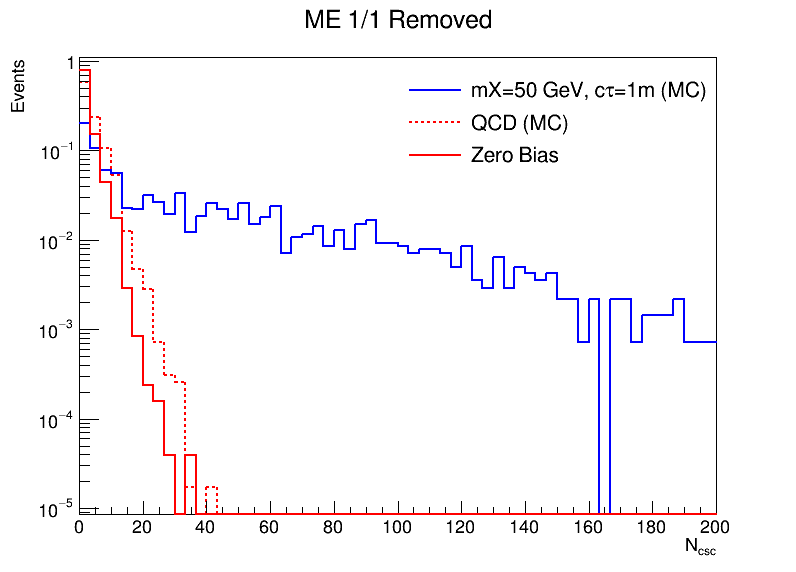

In [13]:
# Creates a 1D histogram of the number of CSC hits for the m50ct1m signal MC, QCD MC, and ZeroBias data
# after removing hits in ME 1/1

c2 = rt.TCanvas('c2','c2', 800, 600)

h['nCsc_m50ct1m_noME11'] = create_TH1D(nCsc_removal['m50ct1m']['ME_11'], axis_title=['nCsc_m50ct1m_noME11', 'Events'], name='nCsc_m50ct1m_noME11', binning=[150,0,500])
h['nCsc_m50ct1m_noME11'].SetLineColor(4)

h['nCsc_qcd_noME11'] = create_TH1D(nCsc_removal['qcd']['ME_11'], axis_title=['nCsc_qcd_noME11', 'Events'], name='nCsc_qcd_noME11', binning=[150,0,500])
h['nCsc_qcd_noME11'].SetLineColor(2)
h['nCsc_qcd_noME11'].SetLineStyle(2)


h['nCsc_zeroBias_noME11'] = create_TH1D(nCsc_removal['zeroBias']['ME_11'], axis_title=['nCsc_zeroBias_noME11', 'Events'], name='nCsc_zeroBias_noME11', binning=[150,0,500])
h['nCsc_zeroBias_noME11'].SetLineColor(2)
h['nCsc_zeroBias_noME11'].SetLineStyle(1)

c2.SetLogy()

h['nCsc_m50ct1m_noME11'].Scale(1.0/h['nCsc_m50ct1m_noME11'].Integral())
h['nCsc_qcd_noME11'].Scale(1.0/h['nCsc_qcd_noME11'].Integral())
h['nCsc_zeroBias_noME11'].Scale(1.0/h['nCsc_zeroBias_noME11'].Integral())


h['nCsc_m50ct1m_noME11'].SetLineWidth(2)
h['nCsc_qcd_noME11'].SetLineWidth(2)
h['nCsc_zeroBias_noME11'].SetLineWidth(2)

h['nCsc_m50ct1m_noME11'].GetXaxis().SetRangeUser(0,200)
h['nCsc_qcd_noME11'].GetXaxis().SetRangeUser(0,200)
h['nCsc_zeroBias_noME11'].GetXaxis().SetRangeUser(0,200)


h['nCsc_qcd_noME11'].SetStats(0)
h['nCsc_qcd_noME11'].SetTitle("ME 1/1 Removed")
h['nCsc_qcd_noME11'].SetXTitle("N_{csc}")


h['nCsc_qcd_noME11'].Draw('histo')
h['nCsc_m50ct1m_noME11'].Draw('histo+same')
h['nCsc_zeroBias_noME11'].Draw('histo+same')

legend = rt.TLegend(0.50,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
#legend-.SetFillStyle(0);
legend.AddEntry( h['nCsc_m50ct1m_noME11'], "mX=50 GeV, c#tau=1m (MC)" , "L");
legend.AddEntry( h['nCsc_qcd_noME11'], "QCD (MC)" , "L");
legend.AddEntry( h['nCsc_zeroBias_noME11'], "Zero Bias" , "L");

legend.Draw();

c2.Draw()

c2.SaveAs("ncsc_noME11_mc_zeroBias.pdf")
c2.SaveAs("ncsc_noME11_mc_zeroBias.C")

## Calculations for N<sub>CSC</sub> Threshold ROC Curves

In [14]:
# Calculations for ROC Curves for ggH/QCD/ZeroBias Samples: nCsc/nDt/nRpc 

# Calculates efficiency by calculating the fraction of events that pass nCsc/nDt/nRpc thresholds

eff_ncsc = {}
eff_ndt = {}
eff_nrpc = {}
rejection_power = {}
ncsc_var_x = np.array([])
ndt_var_x = np.array([])

# Iterates over every datafile
for data_type in data_trees.keys():
    eff_ncsc[data_type] = {}
    eff_ndt[data_type] = {}
    eff_nrpc[data_type] = {}
      
    # No clustering: Endcap
    eff_ncsc[data_type]['noCluster'] = {}
    eff_ncsc[data_type]['noCluster']['csc_inclusive'] = np.array([])
    eff_ncsc[data_type]['noCluster']['csc_noME11'] = np.array([])
    eff_ncsc[data_type]['noCluster']['csc_noME112'] = np.array([])
    eff_ncsc[data_type]['noCluster']['csc_noME1123'] = np.array([])
    
    # No clustering: Barrel
    eff_ndt[data_type]['noCluster'] = {}
    eff_ndt[data_type]['noCluster']['dt_inclusive'] = np.array([])
    eff_ndt[data_type]['noCluster']['dt_noMB11'] = np.array([])
    eff_ndt[data_type]['noCluster']['dt_noMB112'] = np.array([])
        
    # No clustering: Overlap
    eff_nrpc[data_type]['noCluster'] = {}
    eff_nrpc[data_type]['noCluster']['rpc_inclusive'] = np.array([])
    
    for hit_thresh in range(0, 200):
        ncsc_var_x = np.append(ncsc_var_x, hit_thresh)
        
        # No-Clustering ROCs
        # Endcap
        eff_ncsc[data_type]['noCluster']['csc_inclusive'] = np.append(eff_ncsc[data_type]['noCluster']['csc_inclusive'], np.count_nonzero(np.array(nCsc[data_type])>hit_thresh)/len(nCsc[data_type]))
        eff_ncsc[data_type]['noCluster']['csc_noME11'] = np.append(eff_ncsc[data_type]['noCluster']['csc_noME11'], np.count_nonzero(np.array(nCsc_removal[data_type]['ME_11'])>hit_thresh)/len(nCsc_removal[data_type]['ME_11']))
        eff_ncsc[data_type]['noCluster']['csc_noME112'] = np.append(eff_ncsc[data_type]['noCluster']['csc_noME112'], np.count_nonzero(np.array(nCsc_removal[data_type]['ME_112'])>hit_thresh)/len(nCsc_removal[data_type]['ME_112']))
        eff_ncsc[data_type]['noCluster']['csc_noME1123'] = np.append(eff_ncsc[data_type]['noCluster']['csc_noME1123'], np.count_nonzero(np.array(nCsc_removal[data_type]['ME_1123'])>hit_thresh)/len(nCsc_removal[data_type]['ME_1123']))

        # Overlap
        eff_nrpc[data_type]['noCluster']['rpc_inclusive'] = np.append(eff_nrpc[data_type]['noCluster']['rpc_inclusive'], np.count_nonzero(np.array(nRpc[data_type])>hit_thresh)/len(nRpc[data_type]))

    # Rejection power calculation
    rejection_power[data_type] = {}
    rejection_power[data_type]['noCluster'] = {}
    
    # No clustering
    rejection_power[data_type]['noCluster']['csc_inclusive'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['noCluster']['csc_inclusive']))
    rejection_power[data_type]['noCluster']['csc_noME11'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['noCluster']['csc_noME11']))
    rejection_power[data_type]['noCluster']['csc_noME112'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['noCluster']['csc_noME112']))
    rejection_power[data_type]['noCluster']['csc_noME1123'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['noCluster']['csc_noME1123']))

    rejection_power[data_type]['noCluster']['rpc_inclusive'] = np.reciprocal(np.trim_zeros(eff_nrpc[data_type]['noCluster']['rpc_inclusive']))

    # For the high LLP mass, low ctau sample (m975ct1m) , none of the events pass the barrel cut and thus I hard-coded a 
    # way to avoid divide-by-zero errors later on when plotting ROC curves by simpling not recording any barrel datapoints
    # for this sample.
    if data_type != 'm975ct1m':
        
        for hit_thresh in range(0, 200):
            ndt_var_x = np.append(ndt_var_x, hit_thresh)
            
            # No-Clustering ROCs
            # Barrel
            eff_ndt[data_type]['noCluster']['dt_inclusive'] = np.append(eff_ndt[data_type]['noCluster']['dt_inclusive'], np.count_nonzero(np.array(nDt[data_type])>hit_thresh)/len(nDt[data_type]))
            eff_ndt[data_type]['noCluster']['dt_noMB11'] = np.append(eff_ndt[data_type]['noCluster']['dt_noMB11'], np.count_nonzero(np.array(nDt_removal[data_type]['MB_11'])>hit_thresh)/len(nDt_removal[data_type]['MB_11']))
            eff_ndt[data_type]['noCluster']['dt_noMB112'] = np.append(eff_ndt[data_type]['noCluster']['dt_noMB112'], np.count_nonzero(np.array(nDt_removal[data_type]['MB_112'])>hit_thresh)/len(nDt_removal[data_type]['MB_112']))
            
        # No clustering
        rejection_power[data_type]['noCluster']['dt_inclusive'] = np.reciprocal(np.trim_zeros(eff_ndt[data_type]['noCluster']['dt_inclusive']))
        rejection_power[data_type]['noCluster']['dt_noMB11'] = np.reciprocal(np.trim_zeros(eff_ndt[data_type]['noCluster']['dt_noMB11']))
        rejection_power[data_type]['noCluster']['dt_noMB112'] = np.reciprocal(np.trim_zeros(eff_ndt[data_type]['noCluster']['dt_noMB112']))
                

## *N<sub>CSC</sub> Threshold ROC Curves*

length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!


Warning in <TLegend::Paint>: Legend to large to be automatically placed. A default position is used


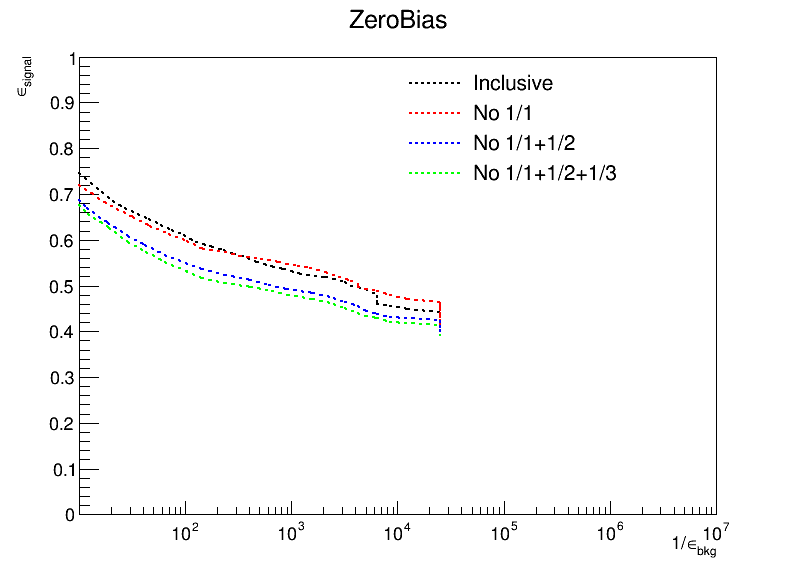

In [15]:
# Creates ROC curves for the signal efficiency of the m50ct1m signal sample against the ZeroBias samples
# using nCsc thresholds

c3 = rt.TCanvas('c3','c3', 800, 600)

h['roc_curve_noCluster'] = create_TGraph(rejection_power['zeroBias']['noCluster']['csc_inclusive'], eff_ncsc['m50ct1m']['noCluster']['csc_inclusive'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_clean_noCluster'] = create_TGraph(rejection_power['zeroBias']['noCluster']['csc_noME11'], eff_ncsc['m50ct1m']['noCluster']['csc_noME11'], axis_title=['#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_res_noCluster'] = create_TGraph(rejection_power['zeroBias']['noCluster']['csc_noME1123'], eff_ncsc['m50ct1m']['noCluster']['csc_noME1123'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_med_noCluster'] = create_TGraph(rejection_power['zeroBias']['noCluster']['csc_noME112'], eff_ncsc['m50ct1m']['noCluster']['csc_noME112'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])

c3.SetLogx()

h['roc_curve_noCluster'].SetTitle('ZeroBias')


h['roc_curve_noCluster'].SetLineWidth(2)
h['roc_curve_clean_noCluster'].SetLineWidth(2)
h['roc_curve_res_noCluster'].SetLineWidth(2)
h['roc_curve_med_noCluster'].SetLineWidth(2)

h['roc_curve_noCluster'].SetLineColor(1)
h['roc_curve_noCluster'].SetLineStyle(2)

h['roc_curve_clean_noCluster'].SetLineColor(2)
h['roc_curve_clean_noCluster'].SetLineStyle(2)
                                          
h['roc_curve_res_noCluster'].SetLineColor(3)
h['roc_curve_res_noCluster'].SetLineStyle(2)

h['roc_curve_med_noCluster'].SetLineColor(4)
h['roc_curve_med_noCluster'].SetLineStyle(2)

h['roc_curve_noCluster'].GetXaxis().SetLimits(10, 10000000)
h['roc_curve_noCluster'].GetYaxis().SetRangeUser(0,1)

h['roc_curve_noCluster'].Draw()
h['roc_curve_clean_noCluster'].Draw('same')

h['roc_curve_res_noCluster'].Draw('same')
h['roc_curve_med_noCluster'].Draw('same')

legend = rt.TLegend(0.70,0.70,0.7,0.7);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);

legend.AddEntry( h['roc_curve_noCluster'], "Inclusive", 'l');
legend.AddEntry( h['roc_curve_clean_noCluster'], "No 1/1", 'l');
legend.AddEntry( h['roc_curve_med_noCluster'], "No 1/1+1/2", 'l');
legend.AddEntry( h['roc_curve_res_noCluster'], "No 1/1+1/2+1/3", 'l');


legend.Draw();

c3.Draw()

# Barrel Offline Studies

## Barrel Hit Removal

In [27]:
# Hit removal done identically to that of the endcap

# Barrel
nDt_station = {}
nDt_removal = {}

# Loops over every datafile
for files in data_trees.keys():
    # Barrel
    nDt_station[files] = {}
    nDt_station[files]['MB_1'] = []
    nDt_station[files]['MB_2'] = []
    nDt_station[files]['MB_3'] = []
    nDt_station[files]['MB_4'] = []
    
    # Loops over every event in each datafile
    for pos_bool in range(len(dt_z[files])):
        dt_r = np.sqrt(dt_x[files][pos_bool]**2+dt_y[files][pos_bool]**2)
        z_pos_bool = dt_z[files][pos_bool]
        
        counter_mb1 = 0
        counter_mb2 = 0
        counter_mb3 = 0
        counter_mb4 = 0
        
        # Loops over every hit in each event
        for z_ind in range(len(z_pos_bool)):
            z_bool = np.absolute(z_pos_bool[z_ind])
            if z_bool > -661 and z_bool < 661:
                
                # MB 1 Constraints
                if dt_r[z_ind] < 449 and dt_r[z_ind] > 402:
                    counter_mb1 += 1
                # MB 2 Constraints
                if dt_r[z_ind] < 533.5 and dt_r[z_ind] > 490.5:
                    counter_mb2 += 1
                # MB 3 Constraints
                if dt_r[z_ind] < 636 and dt_r[z_ind] > 597.5:
                    counter_mb3 += 1
                # MB 4 Constraints
                if dt_r[z_ind] < 738 and dt_r[z_ind] > 700:
                    counter_mb4 += 1
                    
        nDt_station[files]['MB_1'].append(counter_mb1)
        nDt_station[files]['MB_2'].append(counter_mb2)
        nDt_station[files]['MB_3'].append(counter_mb3)
        nDt_station[files]['MB_4'].append(counter_mb4)    
    
    # nDt dictionaries containing hits removed labelled by removed stations
    nDt_removal[files] = {}
    nDt_removal[files]['MB_1'] = np.array(nDt[files]) - np.array(nDt_station[files]['MB_1'])
    nDt_removal[files]['MB_12'] = np.array(nDt[files]) - (np.array(nDt_station[files]['MB_1']) + np.array(nDt_station[files]['MB_2']))
    
    print(files + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

m50ct1m: 2019-07-25 15:44:02.829869-07:00
qcd: 2019-07-25 15:44:07.555457-07:00
zeroBias: 2019-07-25 15:44:10.861882-07:00
m50ct10m: 2019-07-25 15:44:12.556115-07:00
m975ct1m: 2019-07-25 15:44:12.556246-07:00
m975ct10m: 2019-07-25 15:44:13.362327-07:00


## *Barrel Inclusive N<sub>DT</sub> Histogram*

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c4
Warning in <TROOT::Append>: Replacing existing TH1: nDt_qcd (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nDt_zeroBias (Potential memory leak).


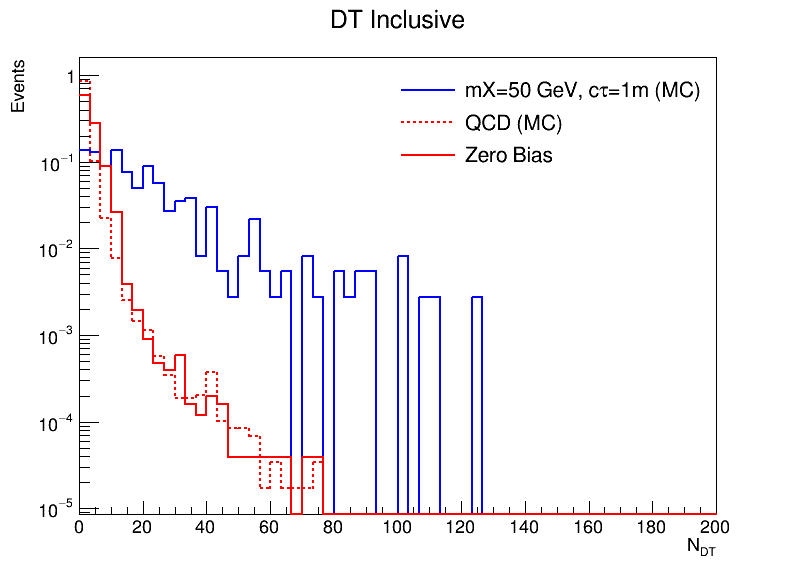

In [34]:
# Creates a 1D histogram of the number of DT hits for the m50ct1m signal MC, QCD MC, and ZeroBias data
# with no hit removal

c4 = rt.TCanvas('c4','c4', 800, 600)
h['nDt_m50ct1m'] = create_TH1D(nDt['m50ct1m'], axis_title=['nDt_m50ct1m', 'Events'], name='nDt_m50ct1m', binning=[150,0,500])
h['nDt_m50ct1m'].SetLineColor(4)

h['nDt_qcd'] = create_TH1D(nDt['qcd'], axis_title=['nDt_qcd', 'Events'], name='nDt_qcd', binning=[150,0,500])
h['nDt_qcd'].SetLineColor(2)
h['nDt_qcd'].SetLineStyle(2)


h['nDt_zeroBias'] = create_TH1D(nDt['zeroBias'], axis_title=['nDt_zeroBias', 'Events'], name='nDt_zeroBias', binning=[150,0,500])
h['nDt_zeroBias'].SetLineColor(2)
h['nDt_zeroBias'].SetLineStyle(1)

c4.SetLogy()

h['nDt_m50ct1m'].Scale(1.0/h['nDt_m50ct1m'].Integral())
h['nDt_qcd'].Scale(1.0/h['nDt_qcd'].Integral())
h['nDt_zeroBias'].Scale(1.0/h['nDt_zeroBias'].Integral())


h['nDt_m50ct1m'].SetLineWidth(2)
h['nDt_qcd'].SetLineWidth(2)
h['nDt_zeroBias'].SetLineWidth(2)

h['nDt_m50ct1m'].GetXaxis().SetRangeUser(0,200)
h['nDt_qcd'].GetXaxis().SetRangeUser(0,200)
h['nDt_zeroBias'].GetXaxis().SetRangeUser(0,200)


h['nDt_qcd'].SetStats(0)
h['nDt_qcd'].SetTitle("DT Inclusive")
h['nDt_qcd'].SetXTitle("N_{DT}")


h['nDt_qcd'].Draw('histo')
h['nDt_m50ct1m'].Draw('histo+same')
h['nDt_zeroBias'].Draw('histo+same')

legend = rt.TLegend(0.49,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.AddEntry( h['nDt_m50ct1m'], "mX=50 GeV, c#tau=1m (MC)" , "L");
legend.AddEntry( h['nDt_qcd'], "QCD (MC)" , "L");
legend.AddEntry( h['nDt_zeroBias'], "Zero Bias" , "L");

legend.Draw();

c4.Draw()

## *N<sub>DT</sub> Histogram with MB 1 Hits Removed*

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c5
Warning in <TROOT::Append>: Replacing existing TH1: nDt_m50ct1m_noMB1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nDt_qcd_noMB1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nDt_zeroBias_noMB1 (Potential memory leak).


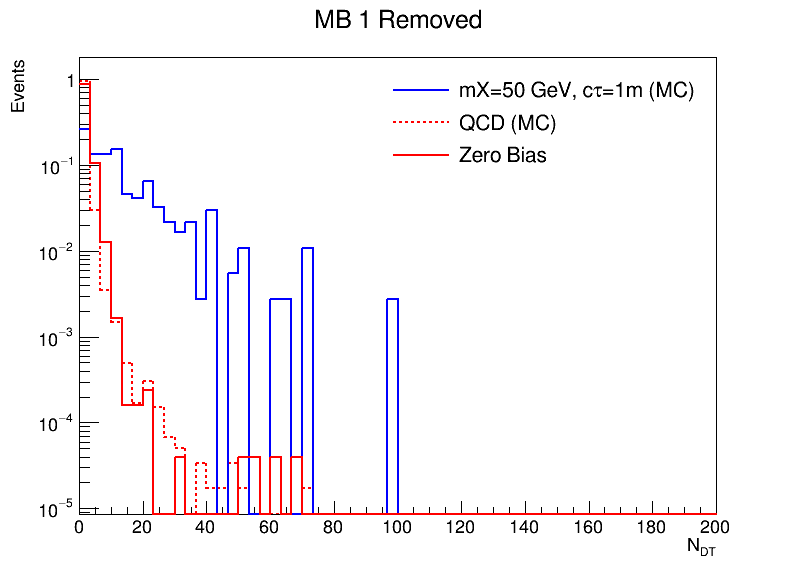

In [33]:
# Creates a 1D histogram of the number of DT hits for the m50ct1m signal MC, QCD MC, and ZeroBias data
# after removing hits in MB 1

c5 = rt.TCanvas('c5','c5', 800, 600)

h['nDt_m50ct1m_noMB1'] = create_TH1D(nDt_removal['m50ct1m']['MB_1'], axis_title=['nDt_m50ct1m_noMB1', 'Events'], name='nDt_m50ct1m_noMB1', binning=[150,0,500])
h['nDt_m50ct1m_noMB1'].SetLineColor(4)

h['nDt_qcd_noMB1'] = create_TH1D(nDt_removal['qcd']['MB_1'], axis_title=['nDt_qcd_noMB1', 'Events'], name='nDt_qcd_noMB1', binning=[150,0,500])
h['nDt_qcd_noMB1'].SetLineColor(2)
h['nDt_qcd_noMB1'].SetLineStyle(2)


h['nDt_zeroBias_noMB1'] = create_TH1D(nDt_removal['zeroBias']['MB_1'], axis_title=['nDt_zeroBias_noMB1', 'Events'], name='nDt_zeroBias_noMB1', binning=[150,0,500])
h['nDt_zeroBias_noMB1'].SetLineColor(2)
h['nDt_zeroBias_noMB1'].SetLineStyle(1)

c5.SetLogy()

h['nDt_m50ct1m_noMB1'].Scale(1.0/h['nDt_m50ct1m_noMB1'].Integral())
h['nDt_qcd_noMB1'].Scale(1.0/h['nDt_qcd_noMB1'].Integral())
h['nDt_zeroBias_noMB1'].Scale(1.0/h['nDt_zeroBias_noMB1'].Integral())


h['nDt_m50ct1m_noMB1'].SetLineWidth(2)
h['nDt_qcd_noMB1'].SetLineWidth(2)
h['nDt_zeroBias_noMB1'].SetLineWidth(2)

h['nDt_qcd_noMB1'].GetXaxis().SetRangeUser(0,200)
h['nDt_qcd_noMB1'].SetStats(0)
h['nDt_qcd_noMB1'].SetTitle("MB 1 Removed")
h['nDt_qcd_noMB1'].SetXTitle("N_{DT}")


h['nDt_qcd_noMB1'].Draw('histo')
h['nDt_m50ct1m_noMB1'].Draw('histo+same')
h['nDt_zeroBias_noMB1'].Draw('histo+same')

legend = rt.TLegend(0.48,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
#legend-.SetFillStyle(0);
legend.AddEntry( h['nDt_m50ct1m_noMB1'], "mX=50 GeV, c#tau=1m (MC)" , "L");
legend.AddEntry( h['nDt_qcd_noMB1'], "QCD (MC)" , "L");
legend.AddEntry( h['nDt_zeroBias_noMB1'], "Zero Bias" , "L");

legend.Draw();

c5.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c5_5
Warning in <TROOT::Append>: Replacing existing TH1: nDt_m50ct1m_MB1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nDt_m50ct1m_MB2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nDt_m50ct1m_MB3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nDt_m50ct1m_MB4 (Potential memory leak).


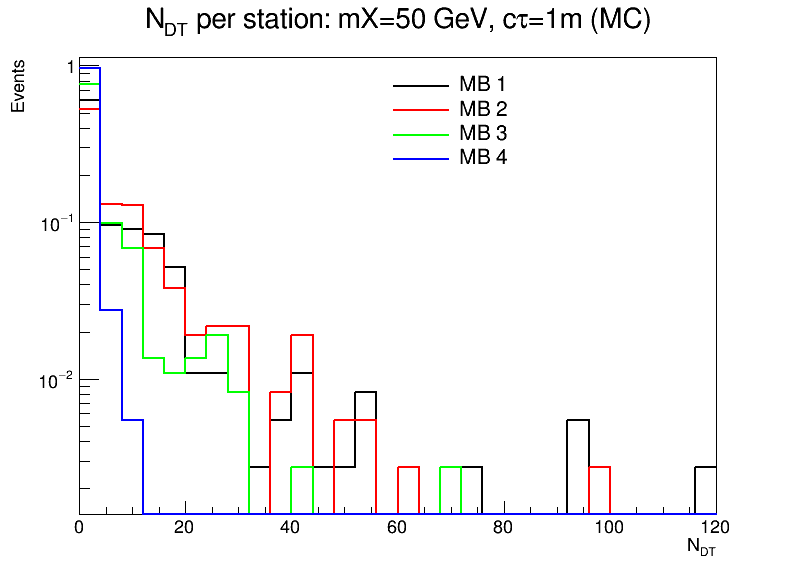

In [38]:
# Creates a 1D histogram of the number of DT hits for the m50ct1m signal MC, QCD MC, and ZeroBias data
# after removing hits in MB 1

c5_5 = rt.TCanvas('c5_5','c5_5', 800, 600)

h['nDt_m50ct1m_MB1'] = create_TH1D(nDt_station['m50ct1m']['MB_1'], axis_title=['nDt_m50ct1m_MB1', 'Events'], name='nDt_m50ct1m_MB1', binning=[50,0,200])
h['nDt_m50ct1m_MB1'].SetLineColor(1)
h['nDt_m50ct1m_MB1'].SetLineWidth(2)

h['nDt_m50ct1m_MB2'] = create_TH1D(nDt_station['m50ct1m']['MB_2'], axis_title=['nDt_m50ct1m_MB2', 'Events'], name='nDt_m50ct1m_MB2', binning=[50,0,200])
h['nDt_m50ct1m_MB2'].SetLineColor(2)
h['nDt_m50ct1m_MB2'].SetLineWidth(2)

h['nDt_m50ct1m_MB3'] = create_TH1D(nDt_station['m50ct1m']['MB_3'], axis_title=['nDt_m50ct1m_MB3', 'Events'], name='nDt_m50ct1m_MB3', binning=[50,0,200])
h['nDt_m50ct1m_MB3'].SetLineColor(3)
h['nDt_m50ct1m_MB3'].SetLineWidth(2)

h['nDt_m50ct1m_MB4'] = create_TH1D(nDt_station['m50ct1m']['MB_4'], axis_title=['nDt_m50ct1m_MB4', 'Events'], name='nDt_m50ct1m_MB4', binning=[50,0,200])
h['nDt_m50ct1m_MB4'].SetLineColor(4)
h['nDt_m50ct1m_MB4'].SetLineWidth(2)

c5_5.SetLogy()

h['nDt_m50ct1m_MB1'].Scale(1.0/h['nDt_m50ct1m_MB1'].Integral())
h['nDt_m50ct1m_MB2'].Scale(1.0/h['nDt_m50ct1m_MB2'].Integral())
h['nDt_m50ct1m_MB3'].Scale(1.0/h['nDt_m50ct1m_MB3'].Integral())
h['nDt_m50ct1m_MB4'].Scale(1.0/h['nDt_m50ct1m_MB4'].Integral())


h['nDt_m50ct1m_MB1'].GetXaxis().SetRangeUser(0,120)
h['nDt_m50ct1m_MB1'].SetStats(0)
h['nDt_m50ct1m_MB1'].SetTitle("N_{DT} per station: mX=50 GeV, c#tau=1m (MC)")
h['nDt_m50ct1m_MB1'].SetXTitle("N_{DT}")


h['nDt_m50ct1m_MB1'].Draw('histo')
h['nDt_m50ct1m_MB2'].Draw('histo+same')
h['nDt_m50ct1m_MB3'].Draw('histo+same')
h['nDt_m50ct1m_MB4'].Draw('histo+same')

legend = rt.TLegend(0.48,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
#legend-.SetFillStyle(0);
legend.AddEntry( h['nDt_m50ct1m_MB1'], "MB 1" , "L");
legend.AddEntry( h['nDt_m50ct1m_MB2'], "MB 2" , "L");
legend.AddEntry( h['nDt_m50ct1m_MB3'], "MB 3" , "L");
legend.AddEntry( h['nDt_m50ct1m_MB4'], "MB 4" , "L");

legend.Draw();

c5_5.Draw()

## *Average Fraction of Hits per DT station*

In [78]:
# ratio_mb_12 = np.array(nDt_station['m50ct1m']['MB_2'])/np.array(nDt_station['m50ct1m']['MB_1'])
# ratio_mb_13 = np.array(nDt_station['m50ct1m']['MB_3'])/np.array(nDt_station['m50ct1m']['MB_1'])
# ratio_mb_14 = np.array(nDt_station['m50ct1m']['MB_4'])/np.array(nDt_station['m50ct1m']['MB_1'])
# ratio_mb_23 = np.array(nDt_station['m50ct1m']['MB_3'])/np.array(nDt_station['m50ct1m']['MB_2'])
# ratio_mb_24 = np.array(nDt_station['m50ct1m']['MB_4'])/np.array(nDt_station['m50ct1m']['MB_2'])
# ratio_mb_34 = np.array(nDt_station['m50ct1m']['MB_4'])/np.array(nDt_station['m50ct1m']['MB_2'])

# barrel_station_ratio = np.dstack((ratio_mb_12, ratio_mb_13, ratio_mb_14, ratio_mb_23, ratio_mb_24, ratio_mb_34))
# barrel_avg_ratio = np.mean(barrel_station_ratio, axis=2)

# # Barrel
# nDt_station = {}
# nDt_removal = {}

# # Loops over every datafile
# for files in data_trees.keys():
#     # Barrel
#     nDt_station[files] = {}
#     nDt_station[files]['MB_1'] = []
#     nDt_station[files]['MB_2'] = []
#     nDt_station[files]['MB_3'] = []
#     nDt_station[files]['MB_4'] = []

nDt_avg_ratio = {}
    
for species in data_trees.keys():
    ratio_mb_1 = np.array(nDt_station[species]['MB_1'])/np.array(nDt[species])
    ratio_mb_2 = np.array(nDt_station[species]['MB_2'])/np.array(nDt[species])
    ratio_mb_3 = np.array(nDt_station[species]['MB_3'])/np.array(nDt[species])
    ratio_mb_4 = np.array(nDt_station[species]['MB_4'])/np.array(nDt[species])
    barrel_station_ratio = np.dstack((ratio_mb_1, ratio_mb_2, ratio_mb_3, ratio_mb_4))
    barrel_avg_ratio = np.mean(barrel_station_ratio, axis=2)
    nDt_avg_ratio[species] = barrel_avg_ratio

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c5_6
Warning in <TROOT::Append>: Replacing existing TH1: nDt_signal_ratio (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nDt_qcd_ratio (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nDt_zeroBias_ratio (Potential memory leak).


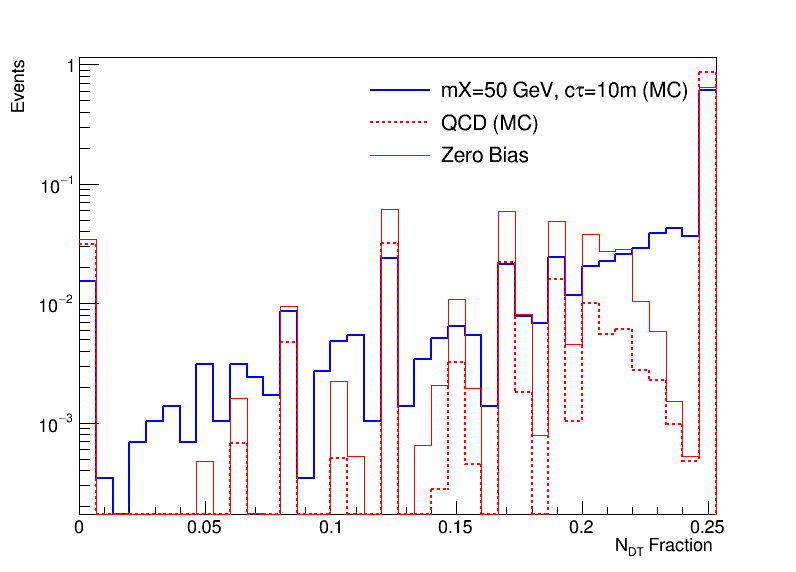

In [89]:
# Creates a 1D histogram of the average fraction of DT hits contributed by each barrel station

c5_6 = rt.TCanvas('c5_6','c5_6', 800, 600)

h['nDt_signal_ratio'] = create_TH1D(nDt_avg_ratio['m50ct10m'][0], axis_title=['nDt_signal_ratio', 'Events'], name='nDt_signal_ratio', binning=[150,0,1])
h['nDt_signal_ratio'].SetLineColor(4)
h['nDt_signal_ratio'].SetLineWidth(2)

h['nDt_qcd_ratio'] = create_TH1D(nDt_avg_ratio['qcd'][0], axis_title=['nDt_qcd_ratio', 'Events'], name='nDt_qcd_ratio', binning=[150,0,1])
h['nDt_qcd_ratio'].SetLineColor(2)
h['nDt_qcd_ratio'].SetLineStyle(2)
h['nDt_qcd_ratio'].SetLineWidth(2)

h['nDt_zeroBias_ratio'] = create_TH1D(nDt_avg_ratio['zeroBias'][0], axis_title=['nDt_zeroBias_ratio', 'Events'], name='nDt_zeroBias_ratio', binning=[150,0,1])
h['nDt_zeroBias_ratio'].SetLineColor(2)
h['nDt_zeroBias_ratio'].SetLineStyle(1)
h['nDt_zeroBias_ratio'].SetLineWidth(1)


c5_6.SetLogy()

h['nDt_signal_ratio'].Scale(1.0/h['nDt_signal_ratio'].Integral())
h['nDt_qcd_ratio'].Scale(1.0/h['nDt_qcd_ratio'].Integral())
h['nDt_zeroBias_ratio'].Scale(1.0/h['nDt_zeroBias_ratio'].Integral())

h['nDt_signal_ratio'].GetXaxis().SetRangeUser(0,0.25)
h['nDt_signal_ratio'].SetStats(0)
h['nDt_signal_ratio'].SetTitle("")
h['nDt_signal_ratio'].SetXTitle("N_{DT} Fraction")


h['nDt_signal_ratio'].Draw('histo')
h['nDt_qcd_ratio'].Draw('histo + same')
h['nDt_zeroBias_ratio'].Draw('histo + same')


legend = rt.TLegend(0.45,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
#legend-.SetFillStyle(0);
legend.AddEntry( h['nDt_signal_ratio'], "mX=50 GeV, c#tau=10m (MC)" , "L");
legend.AddEntry( h['nDt_qcd_ratio'], "QCD (MC)" , "L");
legend.AddEntry( h['nDt_zeroBias_ratio'], "Zero Bias" , "L");

legend.Draw();

c5_6.Draw()

# Overlap Offline Studies

## *Overlap Inclusive N<sub>RPC</sub> Histogram*

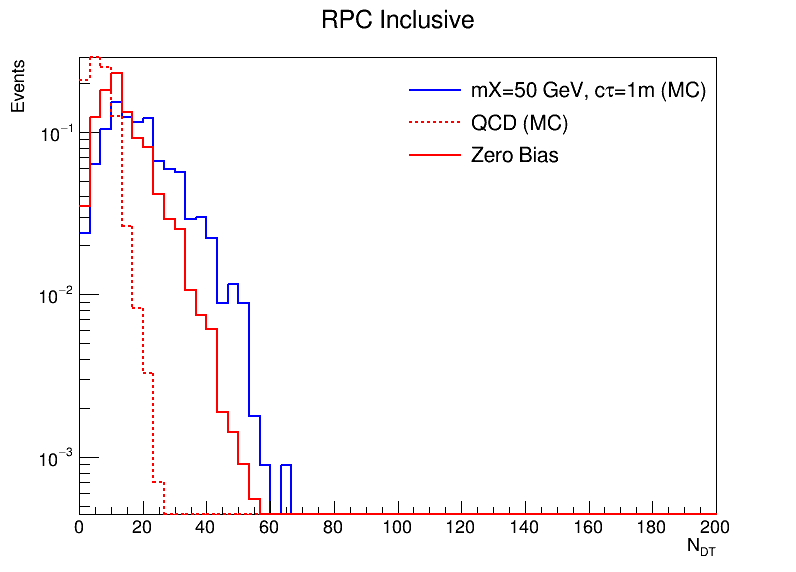

In [18]:
# Creates a 1D histogram of the number of RPC hits for the m50ct1m signal MC, QCD MC, and ZeroBias data
# with no hit removal

c6 = rt.TCanvas('c6','c6', 800, 600)
h['nRpc_m50ct1m'] = create_TH1D(nRpc['m50ct1m'], axis_title=['nRpc_m50ct1m', 'Events'], name='nRpc_m50ct1m', binning=[150,0,500])
h['nRpc_m50ct1m'].SetLineColor(4)

h['nRpc_qcd'] = create_TH1D(nRpc['qcd'], axis_title=['nRpc_qcd', 'Events'], name='nRpc_qcd', binning=[150,0,500])
h['nRpc_qcd'].SetLineColor(2)
h['nRpc_qcd'].SetLineStyle(2)


h['nRpc_zeroBias'] = create_TH1D(nRpc['zeroBias'], axis_title=['nRpc_zeroBias', 'Events'], name='nRpc_zeroBias', binning=[150,0,500])
h['nRpc_zeroBias'].SetLineColor(2)
h['nRpc_zeroBias'].SetLineStyle(1)

c6.SetLogy()

h['nRpc_m50ct1m'].Scale(1.0/h['nRpc_m50ct1m'].Integral())
h['nRpc_qcd'].Scale(1.0/h['nRpc_qcd'].Integral())
h['nRpc_zeroBias'].Scale(1.0/h['nRpc_zeroBias'].Integral())


h['nRpc_m50ct1m'].SetLineWidth(2)
h['nRpc_qcd'].SetLineWidth(2)
h['nRpc_zeroBias'].SetLineWidth(2)

h['nRpc_m50ct1m'].GetXaxis().SetRangeUser(0,200)


h['nRpc_m50ct1m'].SetStats(0)
h['nRpc_m50ct1m'].SetTitle("RPC Inclusive")
h['nRpc_m50ct1m'].SetXTitle("N_{DT}")


h['nRpc_m50ct1m'].Draw('histo')
h['nRpc_qcd'].Draw('histo+same')
h['nRpc_zeroBias'].Draw('histo+same')

legend = rt.TLegend(0.50,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.AddEntry( h['nRpc_m50ct1m'], "mX=50 GeV, c#tau=1m (MC)" , "L");
legend.AddEntry( h['nRpc_qcd'], "QCD (MC)" , "L");
legend.AddEntry( h['nRpc_zeroBias'], "Zero Bias" , "L");

legend.Draw();

c6.Draw()

## *N<sub>DT</sub> Threshold ROC Curves*

length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!


Warning in <TLegend::Paint>: Legend to large to be automatically placed. A default position is used


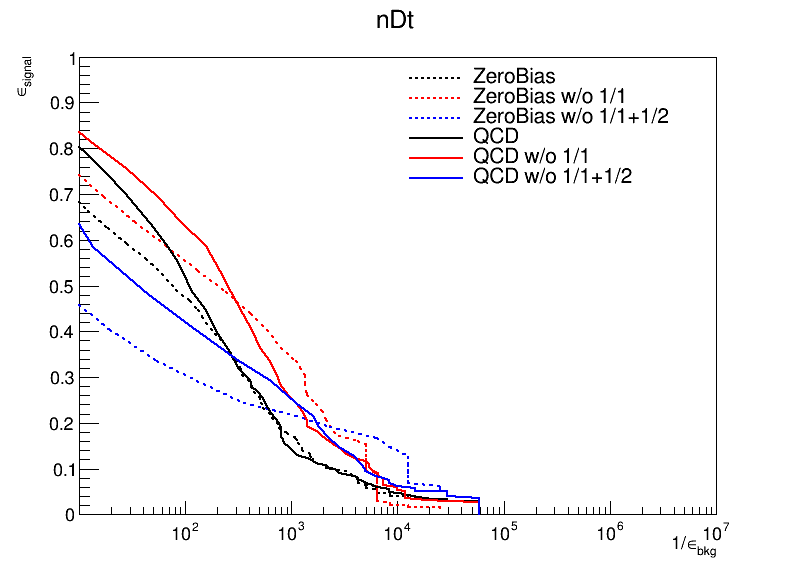

In [19]:
# Creates ROC curves for the signal efficiency of the m50ct1m signal sample against the ZeroBias/QCD samples
# using nDt thresholds

c7 = rt.TCanvas('c7','c7', 800, 600)

h['roc_inclusive_zeroBias'] = create_TGraph(rejection_power['zeroBias']['noCluster']['dt_inclusive'], eff_ndt['m50ct10m']['noCluster']['dt_inclusive'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_no_mb11_zeroBias'] = create_TGraph(rejection_power['zeroBias']['noCluster']['dt_noMB11'], eff_ndt['m50ct10m']['noCluster']['dt_noMB11'], axis_title=['#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_no_mb112_zeroBias'] = create_TGraph(rejection_power['zeroBias']['noCluster']['dt_noMB112'], eff_ndt['m50ct10m']['noCluster']['dt_noMB112'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])

h['roc_inclusive_qcd'] = create_TGraph(rejection_power['qcd']['noCluster']['dt_inclusive'], eff_ndt['m50ct10m']['noCluster']['dt_inclusive'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_no_mb11_qcd'] = create_TGraph(rejection_power['qcd']['noCluster']['dt_noMB11'], eff_ndt['m50ct10m']['noCluster']['dt_noMB11'], axis_title=['#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_no_mb112_qcd'] = create_TGraph(rejection_power['qcd']['noCluster']['dt_noMB112'], eff_ndt['m50ct10m']['noCluster']['dt_noMB112'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])

c7.SetLogx()

h['roc_inclusive_zeroBias'].SetTitle('nDt ')

h['roc_inclusive_zeroBias'].SetLineWidth(2)
h['roc_no_mb11_zeroBias'].SetLineWidth(2)
h['roc_no_mb112_zeroBias'].SetLineWidth(2)

h['roc_inclusive_qcd'].SetLineWidth(2)
h['roc_no_mb11_qcd'].SetLineWidth(2)
h['roc_no_mb112_qcd'].SetLineWidth(2)

### ZeroBias

h['roc_inclusive_zeroBias'].SetLineColor(1)
h['roc_inclusive_zeroBias'].SetLineStyle(2)


h['roc_no_mb11_zeroBias'].SetLineColor(2)
h['roc_no_mb11_zeroBias'].SetLineStyle(2)

h['roc_no_mb112_zeroBias'].SetLineColor(4)
h['roc_no_mb112_zeroBias'].SetLineStyle(2)

### QCD

h['roc_inclusive_qcd'].SetLineColor(1)
h['roc_inclusive_qcd'].SetLineStyle(1)

h['roc_no_mb11_qcd'].SetLineColor(2)
h['roc_no_mb11_qcd'].SetLineStyle(1)

h['roc_no_mb112_qcd'].SetLineColor(4)
h['roc_no_mb112_qcd'].SetLineStyle(1)

####

h['roc_inclusive_zeroBias'].GetXaxis().SetLimits(10, 10000000)
h['roc_inclusive_zeroBias'].GetYaxis().SetRangeUser(0,1)



h['roc_inclusive_zeroBias'].Draw()
h['roc_no_mb11_zeroBias'].Draw('same')
h['roc_no_mb112_zeroBias'].Draw('same')

h['roc_inclusive_qcd'].Draw('same')
h['roc_no_mb11_qcd'].Draw('same')
h['roc_no_mb112_qcd'].Draw('same')


legend = rt.TLegend(0.70,0.70,0.7,0.7);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);

legend.AddEntry( h['roc_inclusive_zeroBias'], "ZeroBias", 'l');
legend.AddEntry( h['roc_no_mb11_zeroBias'], "ZeroBias w/o 1/1", 'l');
legend.AddEntry( h['roc_no_mb112_zeroBias'], "ZeroBias w/o 1/1+1/2", 'l');
legend.AddEntry( h['roc_inclusive_qcd'], "QCD", 'l');
legend.AddEntry( h['roc_no_mb11_qcd'], "QCD w/o 1/1", 'l');
legend.AddEntry( h['roc_no_mb112_qcd'], "QCD w/o 1/1+1/2", 'l');


legend.Draw();

c7.Draw()

## *N<sub>RPC</sub> Threshold ROC Curves*

length of x and y are not equal!
length of x and y are not equal!


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c8
Warning in <TLegend::Paint>: Legend to large to be automatically placed. A default position is used


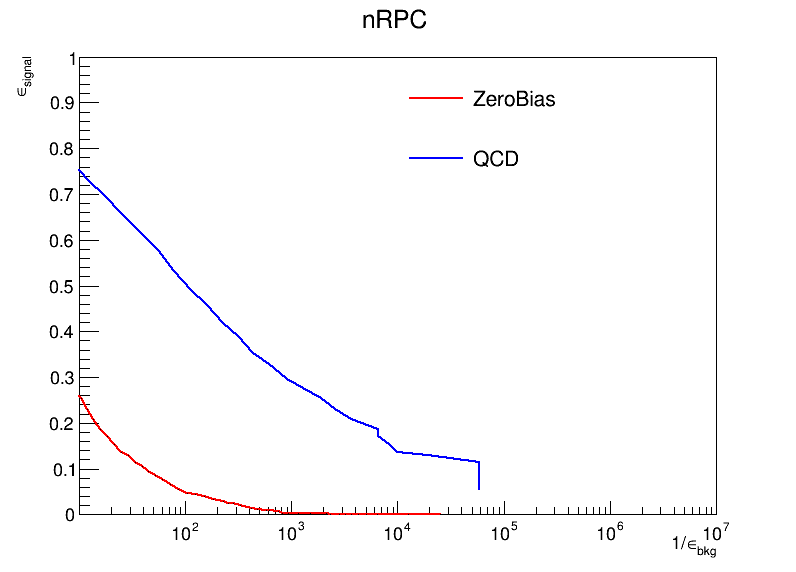

In [21]:
# Creates ROC curves for the signal efficiency of the m50ct1m signal sample against the ZeroBias/QCD samples
# using nRpc thresholds

c8 = rt.TCanvas('c8','c8', 800, 600)

h['roc_inclusive_zeroBias_rpc'] = create_TGraph(rejection_power['zeroBias']['noCluster']['rpc_inclusive'], eff_nrpc['m50ct1m']['noCluster']['rpc_inclusive'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])

h['roc_inclusive_qcd_rpc'] = create_TGraph(rejection_power['qcd']['noCluster']['rpc_inclusive'], eff_nrpc['m50ct1m']['noCluster']['rpc_inclusive'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])

c8.SetLogx()

h['roc_inclusive_zeroBias_rpc'].SetTitle('nRPC ')

h['roc_inclusive_zeroBias_rpc'].SetLineWidth(2)
h['roc_inclusive_qcd_rpc'].SetLineWidth(2)

h['roc_inclusive_zeroBias_rpc'].SetLineColor(2)
h['roc_inclusive_qcd_rpc'].SetLineColor(4)

h['roc_inclusive_zeroBias_rpc'].GetXaxis().SetLimits(10, 10000000)
h['roc_inclusive_zeroBias_rpc'].GetYaxis().SetRangeUser(0,1)



h['roc_inclusive_zeroBias_rpc'].Draw()
h['roc_inclusive_qcd_rpc'].Draw('same')


legend = rt.TLegend(0.70,0.70,0.7,0.7);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);

legend.AddEntry( h['roc_inclusive_zeroBias_rpc'], "ZeroBias", 'l');
legend.AddEntry( h['roc_inclusive_qcd_rpc'], "QCD", 'l');

legend.Draw();

c8.Draw()